# Tehtävä 3-1
### Aihe: Keras Functional API:n käyttö (max. 2 p)


In [1]:
# Kirjoita tähän tietosi!
student_name = 'Jere Soininen'  # Oma nimesi
student_id = 'AB6802' # Oma opiskelijatunnuksesi JAMK:ssa



1. Luo alla olevan kuvan mukainen neuroverkko, jossa on useampi sisääntulo.
    * Kerroksien neuronien määrällä tai aktivointifunktiolla ei ole väliä, määritä ne itse vapaasti.
2. Aja "Tehtävän vastaukset" solu

Vinkkejä:

* Käytä `Concatenate`-kerrosta yhdistääksesi `Input2`- ja kolmas `Dense`-kerros vasemmalla kuvassa näkyvän Dense-kerroksen sisääntuloksi.
* Samoin käytä `Concatenate`-kerrosta yhdistääksesi `Input3`- ja kolmas `Dense`-kerros oikealla kuvassa näkyvän `Dense`-kerroksen sisääntuloksi.
* Vinkki: `Add`-kerroksen dokumentaatio: https://www.tensorflow.org/api_docs/python/tf/keras/layers/add?hl=th


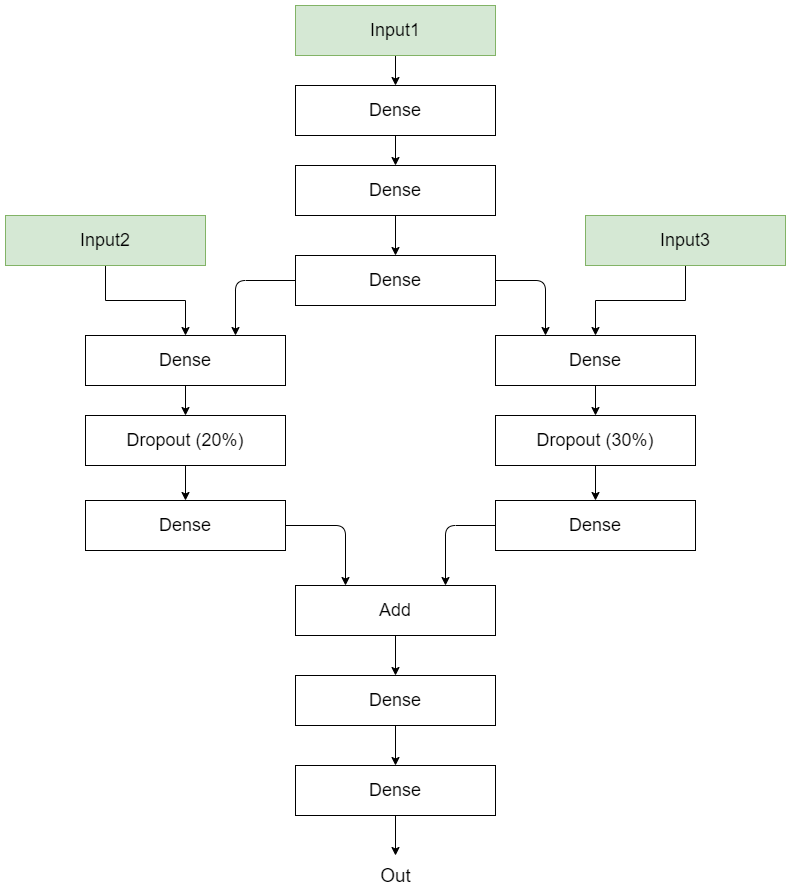

In [2]:
from IPython.display import Image
Image('../img/keras_functional_tehtava.png')

In [3]:
# TODO: Tehtävän toteutus tähän soluun

import tensorflow as tf

# TODO: Määritetään kolme syöttökerrosta (input layer)
input1 = tf.keras.Input(shape=(10,))
input2 = tf.keras.Input(shape=(10,))
input3 = tf.keras.Input(shape=(10,))
# TODO: Keskimmäinen syöte
middle_dense1 = tf.keras.layers.Dense(16, activation='relu')(input1)
middle_dense2 = tf.keras.layers.Dense(8, activation='relu')(middle_dense1)
middle_dense3 = tf.keras.layers.Dense(4, activation='relu')(middle_dense2)


# TODO: vasen haara
left_concat = tf.keras.layers.concatenate([middle_dense3, input2])
left_dense1 = tf.keras.layers.Dense(8, activation='relu')(left_concat)
left_dropout = tf.keras.layers.Dropout(0.2)(left_dense1)
left_dense2 = tf.keras.layers.Dense(2, activation='relu')(left_dropout)


# TODO: oikea haara
# right_concat = tf.keras.layers.concatenate(...)
right_concat = tf.keras.layers.concatenate([middle_dense3, input3])
right_dense1 = tf.keras.layers.Dense(4, activation='relu')(right_concat)
right_dropout = tf.keras.layers.Dropout(0.2)(right_dense1)
right_dense2 = tf.keras.layers.Dense(2, activation='relu')(right_dropout)

# TODO: yhdistetään vasen ja oikea haara Add-kerrokseen
added_layer = tf.keras.layers.add([left_dense2 , right_dense2])
added_dense1 = tf.keras.layers.Dense(16, activation='relu')(added_layer)
added_dense2 = tf.keras.layers.Dense(8, activation='relu')(added_dense1)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(added_dense2)
# TODO: Sijoita luomasi malli model_functional - muuttujaan.
# model_functional = tf.keras.Model(inputs= ..., outputs=...)
model_functional = tf.keras.Model(inputs=[input1, input2, input3],
                               outputs=output_layer)

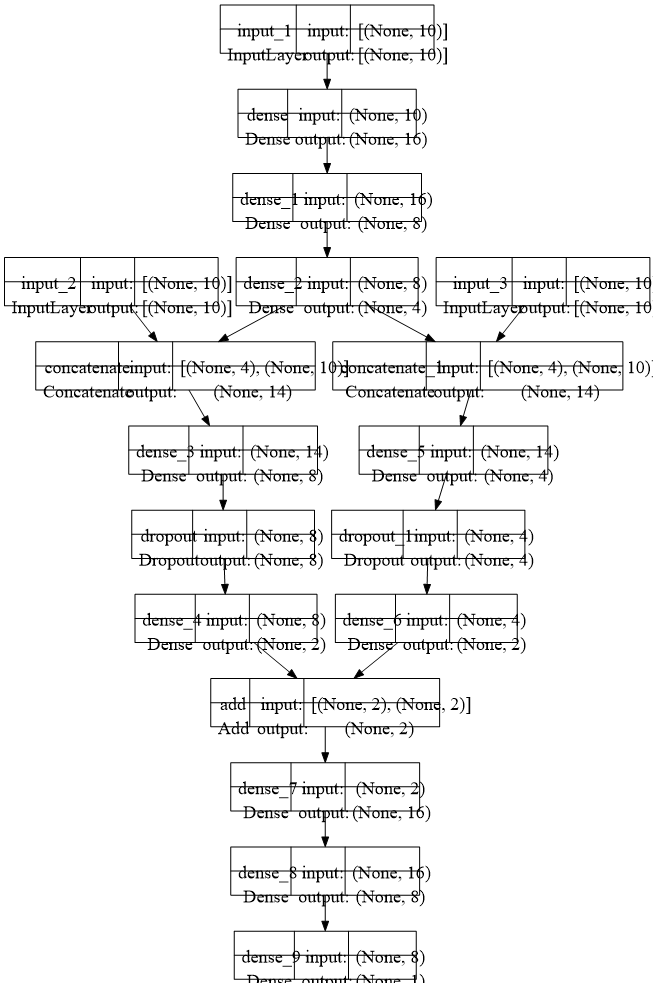

In [4]:
# Tehtävän vastaukset. Huom! Älä muokkaa tätä solua, vaan aja se, kun olet suorittanut tehtävän. Sijoita luomasi malli model_functional - muuttujaan.

from IPython.display import SVG

# Piirretään kuva suoraan Jupyter Notebook-dokumenttiin esim. ao. luokilla
# tässä concatit ja output näkyy "ylimääräisinä" palikoina mutta uskoisin silti että kuva on tehtävän annon
# mukainen tai ainakin hyvin lähellä
svg = tf.keras.utils.plot_model(model_functional, dpi=70, show_shapes=True)

svg

In [5]:
# Tehtävän vastaukset. Huom! Älä muokkaa tätä solua, vaan aja se, kun olet suorittanut tehtävän. Sijoita luomasi malli model_functional - muuttujaan.
model_functional.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 16)           176         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 8)            136         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 4)            36          ['dense_1[0][0]']                
                                                                                              

# Tehtävä 3-2
### Aihe: Konvoluutioneuroverkko ja feature - matriisit (max. 4 p)

Alkuun hieman taustaa konvoluutioneuroverkoista.

`Conv2D`-tasot muuttavat syöttökuvan matemaattisiksi malliksi, jota tiiviisti kytketyt neuroverkon kerrokset käyttävät luokitteluun (_classification_). Koska `Dense`-kerrokset voivat käsitellä vain 1D-dataa, on muutettava viimeisen `Conv2D`-kerroksen antama moniulotteinen feature map 1D-muotoon `Flatten`-kerroksen avulla.

**Mallin konfigurointia** varten tarvitaan seuraavat tiedot:

* batch size arvoksi 50. Mallille syötetään 50 näytettä jokaisella askeleella.
* Kuvat ovat 32×32 pikselin kokoisia RGB-kuvia, ja ne asetetaan arvoihin `(32, 32, 3)`.
* Häviöfunktio (loss function) on `sparse_categorical_crossentropy` ja `optimizer`-optimoija on `Adam()`.
* Datassa olevia luokkia on `10`.
* **Epoch**-kierrosten määrä on vain _5_ iteraatiota. Reaalimäärässä kierroksia voi olla 50-100, mutta harjoitustehtävissä lisäkierroksista ei suuremmin ole hyötyä.
* Datasta **20%** on testidataa. Loppu on opetusdataa.

**Syötedatan esikäsittely**:

* Tehtävässä käytetään **CIFAR-10** (`tensorflow.keras.datasets`) -aineistoja. ts. `CIFAR-10` -aineisto (_Canadian Institute for Advanced Research_) on kokoelma kuvia, joita käytetään yleisesti koneoppimismallien kouluttamiseen.
* Muuta kuvadata ennen neuroverkkoon sovittamista `float32`-formaattiin, minkä seurauksena koulutusprosessi on nopeampi prosessoida.
* Tietojen skaalaaminen varmistaa, että painoarvojen päivitykset ovat pienempiä, mikä parantaa lopputulosta, koska kaikilla sarakkeilla on yhtä suuri vaikutus lopputulokseen.

**Syväoppimismallin rakentaminen** (dokumentaatiota mukaillen):

When using this layer as the first layer in a model, provide the keyword argument input_shape (tuple of integers, does not include the sample axis). In the example inputs are 28x28 RGB images with 
`channels_last`:

        >>> input_shape = (28, 28, 3)
        >>> convLayer = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), activation='relu', input_shape=input_shape)

Rakennetaan neuroverkkomalli seuraavalla tavalla: 

1. Tehtävässä määritetään kaksi `Conv2D`-kerrosta peräkkäisessä järjestyksessä (3×3 kernel size + ReLU-aktivointi) sekä niille suodatinmääriksi: 32 ja 64.
2. Seuraavaksi käytämme `Flatten`-kerrosta muuntamaan datan yksiulotteiseen muotoon.
3. Luokituksen luomiseen on kaksi `Dense`-kerrosta (suodatinten määrä 64 ja 10). Viimeinen kerros ei aktivoidu ReLU:lla, vaan Softmaxilla, jolloin saadaan moniluokkainen todennäköisyysjakauma vastauksena kysymykseen: "Mikä luokka on todennäköisin tietylle kuvalle?".

**Mallin rakentaminen ja sovittaminen**

Syväoppimisen arkkitehtuurin tai kehyksen määrittelyn jälkeen voimme koota mallin ja sovittaa tiedot (eli aloittaa harjoittelun).

* Käännä malli
* sovita (*fit*) data malliin (`model.compile, model.fit`)
* arvioi mallin tulokset (`model.evaluate`) käyttäen erillistä testidataa.

Tässä tehtävässä **arvioidaan ja tulostetaan** seuraavat muuttujat:

```
Test loss: ??? and Test accuracy: ???
```

In [6]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

# # TODO: Ladataan CIFAR-10 data cifar10.load_data() -metodilla
# input ja target testit vastaus solusta
(train_X, train_y), (input_test, target_test) = cifar10.load_data()

# Syväoppimismallin luominen
# TODO: Skaalataan data parsimisen jälkeen (float32)
train_X, input_test = train_X.astype('float32') / 255.0, input_test.astype('float32') / 255.0
#print(train_X.shape)
 
# CIFAR-10 kuvakoko (32, 32, 3)# TODO: Syväoppimismallin luominen Keras API:n avulla
model_input = tf.keras.Input(shape=(32, 32, 3)) 
# model = Sequential()
#model_conv = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(model_input)
# poolsize 3,3 paransi tulosta joten jätetään se
#model_maxpool = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3))(model_conv)

# tästä tuli vähän sekava mutta suoritin toisen conv kierroksen joka paransi tuloksen 0.60 -> ~ 0.66
# joten se oli mielestäni kannatava muutos ja säilytän sen tässä
model_conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(model_input)
model_maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(model_conv1)
model_conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(model_maxpool1)
model_maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(model_conv2)

model_flatten = tf.keras.layers.Flatten()(model_maxpool2)
model_dense = tf.keras.layers.Dense(64, activation='relu')(model_flatten)
model_out = tf.keras.layers.Dense(10, activation='softmax')(model_dense)

# TODO: Mallin kääntäminen
model = tf.keras.Model(inputs=model_input, outputs=model_out)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# TODO: Sijoitetaan data malliin validation_split=0.2
model.fit(train_X, train_y, epochs=5, batch_size=50, validation_split=0.2, verbose=1)

Epoch 1/5
800/800 [==============================] - 10s 12ms/step - loss: 1.5385 - accuracy: 0.4449 - val_loss: 1.2677 - val_accuracy: 0.5565
Epoch 2/5
800/800 [==============================] - 9s 11ms/step - loss: 1.1560 - accuracy: 0.5926 - val_loss: 1.0971 - val_accuracy: 0.6120
Epoch 3/5
800/800 [==============================] - 9s 11ms/step - loss: 1.0133 - accuracy: 0.6459 - val_loss: 1.0166 - val_accuracy: 0.6403
Epoch 4/5
800/800 [==============================] - 9s 11ms/step - loss: 0.9203 - accuracy: 0.6823 - val_loss: 0.9681 - val_accuracy: 0.6649
Epoch 5/5
800/800 [==============================] - 9s 11ms/step - loss: 0.8533 - accuracy: 0.7027 - val_loss: 0.9473 - val_accuracy: 0.6731


In [7]:
# Tehtävän vastaukset. Huom! Älä muokkaa tätä solua, vaan aja se, kun olet suorittanut tehtävän. 

# TODO: Tulostetaan  yhteenveto (summary) mallista sekä arviointimetriikka - ts. poista kommentit ao. lauseista
model.summary()
score = model.evaluate(input_test, target_test, verbose=0)
print(f'Loss: {score[0]} and accuracy: {score[1]}')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4096)              0   

# Tehtävä 3-3
## Aihe: Uutisotsikoiden luokittelu RNN- tai LSTM-mallin avulla (4 p)

Tässä luokitellaan dataa sillä perusteella, että onko kyseessä ns. **klikkiotsikko** (_clickbait_) vai ei.

Tehtävässä käytetään seuraavaa dataa:
[https://github.com/bhargaviparanjape/clickbait/tree/master/dataset](https://github.com/bhargaviparanjape/clickbait/tree/master/dataset).

### Perusalgoritmi tehtävän toteuttamiseen

1. Lataa aineisto **clickbait_data.txt** ja **non_clickbait_data.txt**-tiedostoista.
2. Aineistossa olevat viestit kuuluvat joka luokkaa _on klikkiotsikko_ (_is clickbait_) == **1** tai _ei ole klikkiotsikko_ (_is not clickbait_) == **0**).
2. Jaetaan data koulutus- ja testidataan (_75%_ koulutusdataa ja _25%_ testidataa jako).
4. Luo RNN-malli, joka ennustaa, onko aineistossa oleva otsikko klikkiotsikko (_clickbait_) vai ei.
5. Ennusta mallin tarkkuus `model.evaluate()` - funktiolla.

## Vinkkejä:

* Käytä numeeriseen muunnokseen `tf.keras.preprocessing.text.Tokenizer` - luokkaa
* Luo otsikoista samanpituiset sekvenssit: (`num_words=sanojen_määrä`)

### Taustatietoa: RNN ja LSTM

_Recurrent neural networks_ (**RNN**) sopii erityisen hyvin peräkkäisten tietojen käsittelylle. Sen tunnettuja käytännön sovelluksia ovat mm. Googlen puhehaku ja Applen Siri.

* RNN sisältää sisäisen muistin.
* RNN on syväoppimisalgoritmi, joka voi muistaa syötteen.
* RNN:n sovelluksia ovat **LSTM** ja **GRU** 
* RNN on suositeltu algoritmi peräkkäisille tiedoille, mm. kirjoitetulle tekstille, aikasarjoille, sääennusteille, taloustiedoille jne.

RNN:ssä data kiertää sisäisessä silmukassa. Kun RNN laskee output-kerroksen, se huomioi myös edellisen kerroksen ja myös sitä edeltävän kerroksen, koska sillä on lyhytaikainen muisti.

**LSTM** (_Long Short-Term Memory_) eroaa RNN:stä siten, että se pystyy paremmin säilyttämään pitkän aikavälin riippuvuuksia datassa. LSTM:ssä on solmut, kuten unohdusportti, tuloportti ja ulostuloportti (engl.  input gate, output gate, forget gate), jotka kontrolloivat tiedon säilyttämistä ja unohtamista. Tämä auttaa LSTM:ää ratkaisemaan RNN:n ongelman, jossa pitkän aikavälin riippuvuuksien muistaminen on haastavaa.

#### Tehtävän voi tehdä kahdella eri tavalla

Pisteitä annettaessa riittää, että on tehnyt toisella ao. tavoista (harjoituksen vuoksi voi tehdä molemmillakin):

1. `SimpleRNN`
2. `LSTM` - Tämä on suositeltavampi tapa tässä tehtävässä. Tällä tavalla saat mitä luultavimmin parempia tuloksia. 

In [8]:
# Tehtävän toteutus
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tehtävän vastaukset. Huom! Älä muokkaa tätä solua, vaan aja se, kun olet suorittanut tehtävän. 
with open("data/clickbait_data.txt", "r", encoding="utf-8") as file:
    clickbait = file.readlines()

with open("data/non_clickbait_data.txt", "r", encoding="utf-8") as file:
    non_clickbait = file.readlines()

data = pd.DataFrame({
    'text': clickbait + non_clickbait,
    'label': [1] * len(clickbait) + [0] * len(non_clickbait)
})

# koulutus- ja testidata jako
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)

words_size = 20000
embedding_dim = 16
max_length = 64

# Luodaan Tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=words_size)
tokenizer.fit_on_texts(train_data['text'].values)


# Muutetaan tekstit sekvenssiksi (opetus- ja testidata)
train_X = tokenizer.texts_to_sequences(train_data['text'].values)
test_X = tokenizer.texts_to_sequences(test_data['text'].values)

# sekvenssit samankokoiseksi (opetus- ja testidata)
train_X = tf.keras.preprocessing.sequence.pad_sequences(train_X, maxlen=max_length)
test_X = tf.keras.preprocessing.sequence.pad_sequences(test_X, maxlen=max_length)

# muunto numpy taulukoksi
train_y = train_data['label'].values
test_y = test_data['label'].values

# siistimpi tapa parametroida malli
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(words_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Määritä optimointimenetelmä ja tappiofunktio
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Kouluta malli
model.fit(train_X, train_y, epochs=10, batch_size=32, validation_data=(test_X, test_y))

# TODO: Sijoita results - muuttujaan funktion model.evaluate() tulos.
results = model.evaluate(test_X, test_y)

# TODO: Muista määrittää model.compile() - funktioon seurattavaksi suureeksi tarkkuus eli metrics=['accuracy'], jotta näet, kuinka suuri osa neuroverkon ennustuksista on oikein.
print(f"Test Loss:{results[0]} Test Accuracy:{results[1]*100}%")

Epoch 1/10
1360/1360 [==============================] - 24s 16ms/step - loss: 0.3769 - accuracy: 0.7901 - val_loss: 0.3379 - val_accuracy: 0.8138
Epoch 2/10
1360/1360 [==============================] - 21s 16ms/step - loss: 0.3148 - accuracy: 0.8227 - val_loss: 0.3380 - val_accuracy: 0.8139
Epoch 3/10
1360/1360 [==============================] - 21s 16ms/step - loss: 0.3033 - accuracy: 0.8264 - val_loss: 0.3456 - val_accuracy: 0.8148
Epoch 4/10
1360/1360 [==============================] - 21s 16ms/step - loss: 0.3007 - accuracy: 0.8271 - val_loss: 0.3883 - val_accuracy: 0.8120
Epoch 5/10
1360/1360 [==============================] - 21s 16ms/step - loss: 0.3015 - accuracy: 0.8266 - val_loss: 0.3661 - val_accuracy: 0.8139
Epoch 6/10
1360/1360 [==============================] - 21s 16ms/step - loss: 0.3006 - accuracy: 0.8271 - val_loss: 0.3674 - val_accuracy: 0.8135
Epoch 7/10
1360/1360 [==============================] - 21s 16ms/step - loss: 0.2994 - accuracy: 0.8274 - val_loss: 0.3996 -

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 16)            320000    
                                                                 
 lstm (LSTM)                 (None, 64, 64)            20736     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 353,697
Trainable params: 353,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1360/1360 [=============================

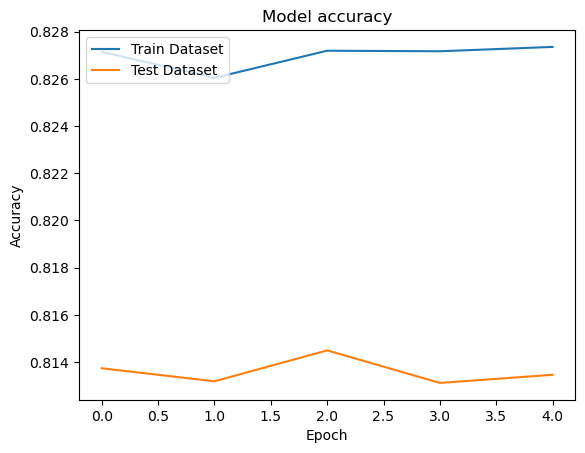

In [9]:
# tämä riittänee, malli suorittaa aika kauan joten ei nyt jaksa hieno säädellä enempää. On kyllä niin siistä miten jokunen python rivi pystyy tekemään tälläisiä ennustuksia mitä tehtiin parissa tehtävässä.
# alempana kuvailu testailua pohjilla jotka olivat materiaalissa.
import matplotlib.pyplot as plt
model.summary()
hist = model.fit(train_X, train_y, epochs=5, batch_size=32, validation_data=(test_X, test_y))

def plot_history(hist):
    plt.plot(hist.history['accuracy'], label="accuracy")
    plt.plot(hist.history['val_accuracy'], label="val_accuracy")
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train Dataset', 'Test Dataset'], loc='upper left')
    plt.show()

plot_history(hist)